# Temperature Anomaly Forecasting for Caribbean Region using XGBoost

In this section, we will use the famous XGBoost (Extreme Gradient Boosting) ML Methos for predicting temperature anomalies for the month or a year. XGBoost is a powerful tree-based method. Although it is not designed specifically for time series data, we can engineer temporal and seasonal features to make it work. Therefore, feature engineering is very important.

In [50]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
#First, let's import out dataset

# Load the dataset

from utils import load_caribbean_weather

df = load_caribbean_weather()

## Create time features

XGBoost needs to have time features for the best model. During our EDA, we added the following features to the original dataframe:

- Rolling statistics: temp_3m(6m, 12m), std_10y
- Lag features

The following needs to be added to point out to the model that temperature anomaly is a time series data.

- Trend features
- Time-based years since start

In [3]:
df.columns

Index(['temp_anomaly', 'precip', 'year', 'month', 'temp_3m', 'temp_6m',
       'temp_12m', 'temp_10y', 'temp_rolling_std', 'season', 'rainy_month',
       'decade', 'precip_log', 'rain_3m', 'rain_6m', 'rain_12m', 'rain_10y',
       'rain_rolling_std', 'temp_anomaly_z', 'precip_log_z', 'temp_trend',
       'precip_trend_log', 'precip_trend', 'temp_trend_lag1',
       'precip_trend_log_lag1', 'precip_trend_log_lag2'],
      dtype='object')

In [93]:
df_t = df[['temp_anomaly', 'year', 'month']].copy()
df_t.head()

,temp_anomaly,year,month
date,,,
1980-01-01,0.29,1980,1
1980-02-01,0.31,1980,2
1980-03-01,0.28,1980,3
1980-04-01,0.29,1980,4
1980-05-01,0.35,1980,5


In [107]:

lags = 12

#Lag features
for lag in range(1, lags + 1):
    df_t[f'temp_lag{lag}'] = df_t['temp_anomaly'].shift(lag)

#Rolling statistics
df_t['temp_rolling_mean_4y'] = df_t['temp_anomaly'].rolling(48).mean()
df_t['temp_rolling_std_4y'] = df_t['temp_anomaly'].rolling(48).std()


# Trend features
df_t['temp_diff1'] = df_t['temp_anomaly'].diff(1)
df_t['temp_diff2'] = df_t['temp_anomaly'].diff(2)

#Time-based
df_t['years-since-start'] = df['year'] - df['year'].min()

In [138]:
df_t.isna().sum()

temp_anomaly             0
year                     0
month                    0
temp_lag1                1
temp_lag2                2
temp_rolling_mean_4y    47
temp_rolling_std_4y     47
temp_diff1               1
temp_diff2               2
years-since-start        0
temp_lag3                3
temp_lag4                4
temp_lag5                5
temp_lag6                6
temp_lag7                7
temp_lag8                8
temp_lag9                9
temp_lag10              10
temp_lag11              11
temp_lag12              12
dtype: int64

### Train/Test Split

In [139]:
#Train/Test split

train = df_t[:-12]
test = df_t[-12:]


feature_cols = ['temp_lag1','temp_lag2','temp_lag3', 'temp_lag4', 
'temp_lag5', 'temp_lag6', 'temp_lag7', 'temp_lag8', 'temp_lag9', 'temp_lag10', 'temp_lag11', 'temp_lag12',
'temp_rolling_mean_4y','temp_rolling_std_4y','temp_diff1', 'temp_diff2', 'years-since-start']

train.dropna()
test.dropna()

X_train = train[feature_cols]
y_train = train['temp_anomaly']

X_test = test[feature_cols]
y_test = test['temp_anomaly']

### Train the XGBoost Model & Forecast

In [132]:
#Train the XGBoost 

xgb_model = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [112]:
#Predict and evaluate

y_pred = xgb_model.predict(X_test)
        

In [113]:
forecast = pd.DataFrame({
    'y_pred': y_pred},
    index = y_test.index
)

forecast

,y_pred
date,
2024-11-01,1.351811
2024-12-01,1.333246
2025-01-01,1.154664
2025-02-01,1.195037
2025-03-01,1.163343
2025-04-01,1.085712
2025-05-01,1.081416
2025-06-01,1.052310
2025-07-01,0.988439


### Forecast Evaluation

In [114]:
true_values = y_test
predicted_values = y_pred

print(f'Evaluation Statistics of the XGBoost Model with 100 estimators')

mae = mean_absolute_error(true_values, predicted_values)
print(f'Mean Absolute Error = {mae}')

mse = mean_squared_error(true_values, predicted_values)
print(f'Mean Squared Error =  {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE) = {rmse}')

score = r2_score(true_values, predicted_values)
print(f'The r2_score  = {score}')

Evaluation Statistics of the XGBoost Model with 100 estimators
Mean Absolute Error = 0.03591174264748892
Mean Squared Error =  0.0030542784389207462
Root Mean Squared Error (RMSE) = 0.05526552667731256
The r2_score  = 0.8667708423589642


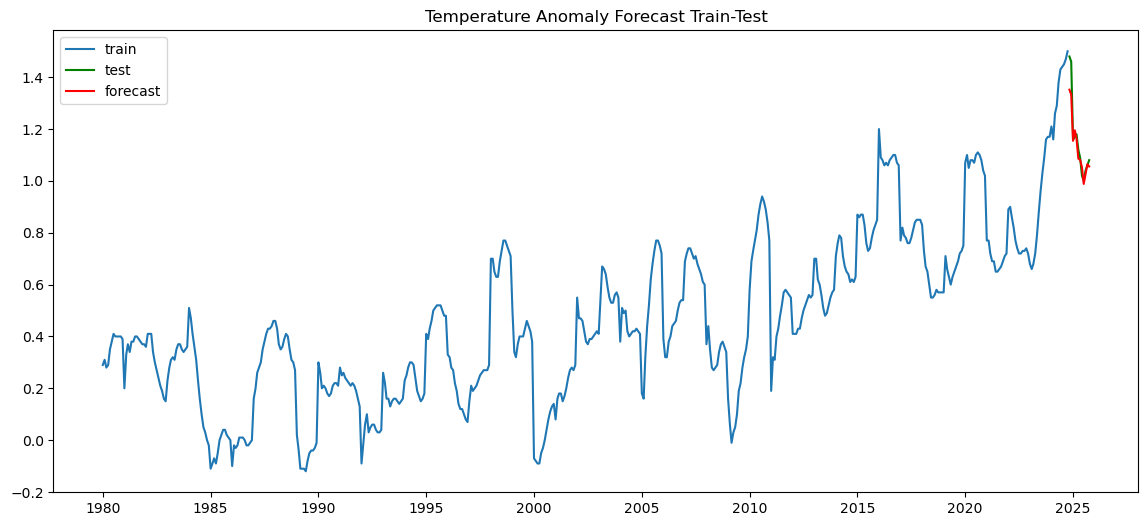

In [115]:
plt.figure(figsize=(14, 6))
plt.plot(y_train, label='train')
plt.plot(y_test, label='test', color='green')
plt.plot(forecast.index, forecast.values, label='forecast', color='red')
plt.title('Temperature Anomaly Forecast Train-Test')
plt.legend()
plt.show()

### Test Forecast Interpretation

The forecasted results of the test set (red line) are very impressive. It almost perfectly aligned the true test values. The XGBoost model was trained using the following parameters:

n_estimators = 100,
max_depth = 3,
learning_rate = 0.05,
subsample = 0.8,
colsample_bytree=0.8,
random_state=42


Evaluation Statistics of the XGBoost Model with 100 estimators:

Mean Absolute Error = 0.03591174264748892
Mean Squared Error =  0.0030542784389207462
Root Mean Squared Error (RMSE) = 0.05526552667731256
The r2_score  = 0.8667708423589642

On average, the model performed very well with MAE=0.035, meaning that the model's predictions are approaximately 0.03 Celsius away from the true values. 
r2 score of 0.86 means that our model's explained 86% of data. 
RMSE of 0.055 means that model's predictions have an error of 0.055 Celsius.

In [116]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

                 feature  importance
0              temp_lag1    0.398814
1              temp_lag2    0.256374
2              temp_lag3    0.194307
12  temp_rolling_mean_4y    0.046384
15            temp_diff2    0.034065
14            temp_diff1    0.023553
4              temp_lag5    0.015128
11            temp_lag12    0.010288
5              temp_lag6    0.008583
13   temp_rolling_std_4y    0.002296
8              temp_lag9    0.002258
9             temp_lag10    0.002208
10            temp_lag11    0.001955
3              temp_lag4    0.001679
7              temp_lag8    0.001452
6              temp_lag7    0.000659
16     years-since-start    0.000000


## Forecasting the future temperature anomalies November 2025 - November 2026



In [122]:
def create_forecast_features(date, historical):

    
    temp_rolling_mean_4y = historical.tail(48).mean()  # Mean of last 48 months (mix of historical + forecasts as we progress)
    temp_rolling_std_4y = historical.tail(48).std()
        
    # Create feature row for prediction
    new_row = {
        'temp_rolling_mean_4y': temp_rolling_mean_4y,
        'temp_rolling_std_4y': temp_rolling_std_4y
    }

    # Dynamically create lags and rolling mean based on updated historical (including prior forecasts)
    lags = 12

    #Lag features
    for lag in range(1, lags + 1):
        new_row[f'temp_lag{lag}'] = historical.iloc[-lag]

    future_X = pd.DataFrame([new_row])

    return future_X
    

In [143]:
# Retrain on full dataset
future_xgb = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 3,
    learning_rate = 0.1,
    subsample = 0.5,
    colsample_bytree=0.8,
    random_state=42
)

feature_cols = feature_cols = ['temp_rolling_mean_4y','temp_rolling_std_4y', 'temp_lag1','temp_lag2','temp_lag3', 'temp_lag4', 
'temp_lag5', 'temp_lag6', 'temp_lag7', 'temp_lag8', 'temp_lag9', 'temp_lag10', 'temp_lag11', 'temp_lag12']

X = df_t[feature_cols]
y = df_t['temp_anomaly']
future_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [144]:
# Iteratively forecast future years
future_predictions = []

# Forecast Next 12 Months (Recursive Forecasting with Dynamic Features)
last_date = df_t.index[-1]
future_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='MS')
historical = df_t['temp_anomaly'].copy()  # Use a copy of historical series for updating lags and rolling mean

# dates
#start_date = datetime(2025, 11, 1)
#end_date = datetime(2026, 11, 1)

#for date in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
for date in future_dates:
    print(date)
    
    # Use previous predictions as features
    X_future = create_forecast_features(date, historical)

    prediction = future_xgb.predict(X_future)[0]
    future_predictions.append(prediction)

    # Update historical with the new prediction for next iteration
    historical = pd.concat([historical, pd.Series([prediction], index=[date])])
    #historical.append(prediction)

    
forecast_df = pd.DataFrame({
    'predicted_temp_anomaly': future_predictions},
    index=future_dates
)

2025-11-01 00:00:00
2025-12-01 00:00:00
2026-01-01 00:00:00
2026-02-01 00:00:00
2026-03-01 00:00:00
2026-04-01 00:00:00
2026-05-01 00:00:00
2026-06-01 00:00:00
2026-07-01 00:00:00
2026-08-01 00:00:00
2026-09-01 00:00:00
2026-10-01 00:00:00


### Visualising future forecasts

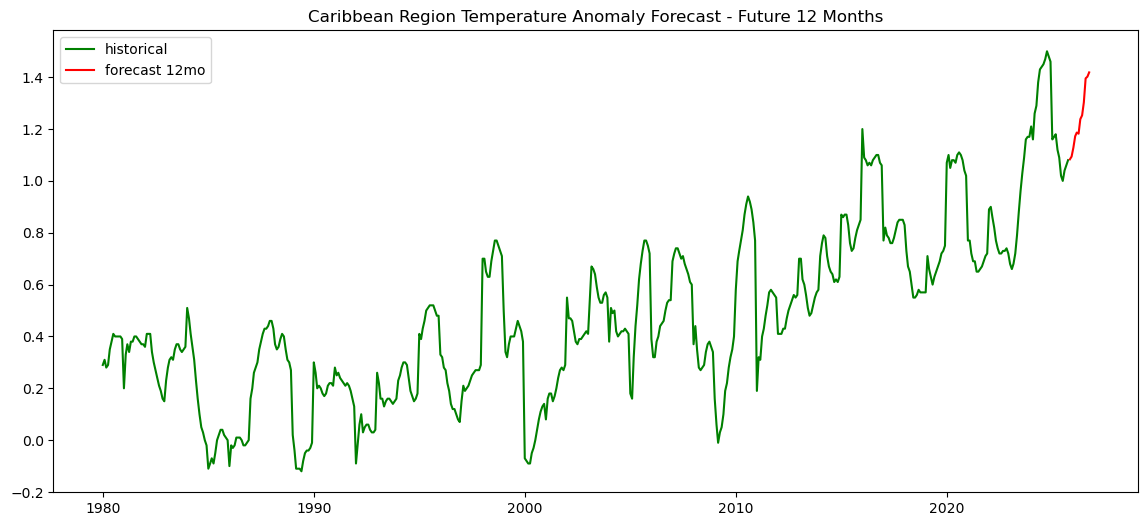

In [145]:
plt.figure(figsize=(14, 6))
plt.plot(y, label='historical', color='green')
plt.plot(forecast_df.index, forecast_df.values, label='forecast 12mo', color='red')
plt.title('Caribbean Region Temperature Anomaly Forecast - Future 12 Months')
plt.legend()
plt.show()

## Tuning the XGBoost Hyperparameters using GridSearch

In [142]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.3, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid = param_grid, cv=4, scoring='neg_mean_squared_error', error_score='raise')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  -0.012323557005397398


In [134]:
X_test.head()

,temp_lag1,temp_lag2,temp_lag3,temp_lag4,temp_lag5,temp_lag6,temp_lag7,temp_lag8,temp_lag9,temp_lag10,temp_lag11,temp_lag12,temp_rolling_mean_4y,temp_rolling_std_4y,temp_diff1,temp_diff2,years-since-start
date,,,,,,,,,,,,,,,,,
2024-11-01,1.50,1.47,1.45,1.44,1.43,1.38,1.29,1.26,1.16,1.21,1.17,1.17,0.933542,0.281920,-0.02,0.01,0
2024-12-01,1.48,1.50,1.47,1.45,1.44,1.43,1.38,1.29,1.26,1.16,1.21,1.17,0.942708,0.291772,-0.02,-0.04,0
2025-01-01,1.46,1.48,1.50,1.47,1.45,1.44,1.43,1.38,1.29,1.26,1.16,1.21,0.950833,0.292290,-0.30,-0.32,0
2025-02-01,1.16,1.46,1.48,1.50,1.47,1.45,1.44,1.43,1.38,1.29,1.26,1.16,0.959167,0.292726,0.01,-0.29,0
2025-03-01,1.17,1.16,1.46,1.48,1.50,1.47,1.45,1.44,1.43,1.38,1.29,1.26,0.968750,0.292259,0.01,0.02,0
